# 🦦 HD-DOTTER PIPELINE

<img src="../imgs/hddotter_logo.png" width="650">

## 📦 Import packages

In [44]:
# Get MNE, a python package for brain data analysis
import mne                          # general MNE functions
import mne_nirs                     # specific for NIRS
from mne.viz import set_3d_view     # for 3D plotting
import nibabel as nib               # for handling nifti files
import pyvista as pv                # for 3D plotting ply files (as meshes)

# Handling hdf5-like files
import h5py                         # for handling hdf5 files (generic)
import snirf                        # for handling snirf files (specific for NIRS)

# For testing purposes only
from mne.datasets.testing import data_path 

# Matrix (array) operations
import numpy as np                  # pronounce it "noom-pee" because it's cuter                 

# Some other useful packages
import os.path as op                # for file path operations
import darkdetect                   # adjusts the plots to dark mode if needed
import matplotlib.pyplot as plt     # for general plotting if needed
import os                           # for general file operations

## 💿 Load the data

### 🧪 Test data
Uncomment the cell below to run.

In [2]:
'''testing_path = data_path(download=True)
fname = op.join(testing_path, 'SNIRF', 'GowerLabs', 'lumomat-1-1-0.snirf')
raw = mne.io.read_raw_snirf(fname, preload=True)'''

"testing_path = data_path(download=True)\nfname = op.join(testing_path, 'SNIRF', 'GowerLabs', 'lumomat-1-1-0.snirf')\nraw = mne.io.read_raw_snirf(fname, preload=True)"

### 📋 Fill in some experiment data

In [76]:
# Who participated in the experiment? (Works for both species.)
subject_name = 'odin'

# Whose template should we use? (odin, barney, kunkun) 
# Works with dogs only. For humans, define template on the go!
template_name = 'odin'

## ፨ SNIRF data
<span style="color:orange">Important:</span> Lumo provides data in .lufr format. First you need to convert it to .snirf in Matlab using the lufr_converter.m script.

In [55]:
# Path to the data (Do not touch)
snirf_path = '../data/snirf/' + subject_name + '.snirf'

# This reads the data and displays the main information (Do not touch)
raw = mne.io.read_raw_snirf(snirf_path, preload=True)
raw

Loading /home/rblc/ELTE/hddotter/scripts/../data/snirf/odin.snirf
Reading 0 ... 1892  =      0.000 ...   151.360 secs...


/tmp/ipykernel_5858/2942977569.py:5: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of unknownunknown
  raw = mne.io.read_raw_snirf(snirf_path, preload=True)


<RawSNIRF | odin.snirf, 3456 x 1893 (151.4 s), ~52.6 MB, data loaded>

In [56]:
raw.get_data().shape

(3456, 1893)

Let's make a rough plot. 

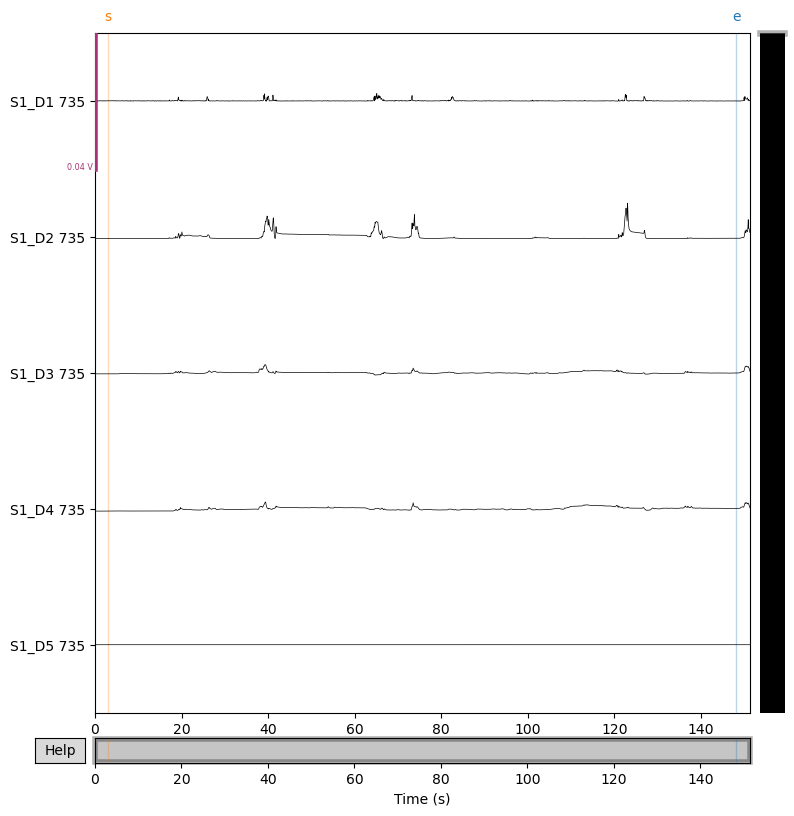

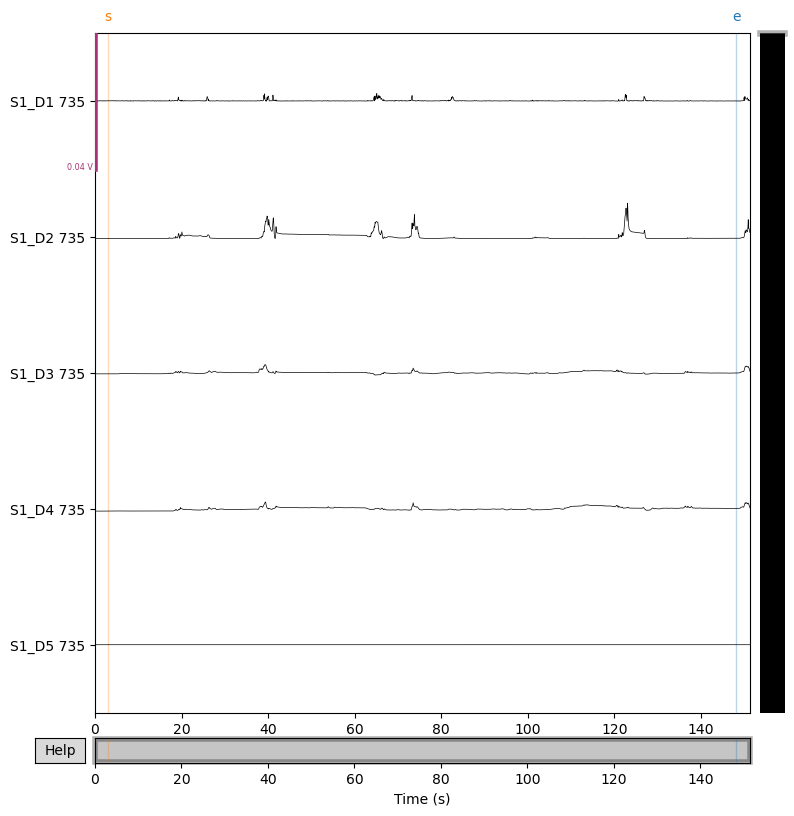

In [57]:
raw.plot(duration=600,          # Set it longer than the measurement, so you see all.
        n_channels=5,           # Look at the first 5 channels only.
        remove_dc=True)         # Remove the DC component from the data.

In [58]:
raw.annotations.to_data_frame()

,onset,duration,description
0,2000-01-01 00:00:03.000,0.0,s
1,2000-01-01 00:02:28.137,0.0,e


<span style='color:yellow'>Things to improve:</span>
- The interactive slider doesn't work in this notebook. Oh well.
- No clue what these codes are (eg. S1_D1).
- I only see the 735 nm channels. I assume the 850 would be below.
- No clue what the DC component removal does. I don't see difference. 

## 🧭 Location
This section is mostly for exploratory purposes. Although the initial idea was to update "default" sensor locations with accurately recorded ones, it might be easier to do in Matlab using the Lumomat toolbox.

### ⛔️ Channel locations 
This is most likely a dead end. I found the channel locations so far. I have no clue what point coordinates are for a line-like object. I'm also unsure what the scale is (possibly meters).

In [59]:
for idx, ch in enumerate(raw.info['chs']):
    loc = ch['loc'][:3]                         # First three elements are the x, y, z coordinates
    print(f"Channel {idx}: Location - {loc}")

Channel 0: Location - [0.11957488 0.05238817 0.01      ]
Channel 1: Location - [0.11270807 0.0558238  0.01      ]
Channel 2: Location - [0.11714071 0.05606627 0.01      ]
Channel 3: Location - [0.11913918 0.05998684 0.01      ]
Channel 4: Location - [0.13764458 0.06788885 0.01      ]
Channel 5: Location - [0.13831155 0.06023879 0.01      ]
Channel 6: Location - [0.1357759  0.06386126 0.01      ]
Channel 7: Location - [0.13137156 0.06345614 0.01      ]
Channel 8: Location - [0.12951848 0.08557219 0.01      ]
Channel 9: Location - [0.13629407 0.08920117 0.01      ]
Channel 10: Location - [0.1339514  0.08542976 0.01      ]
Channel 11: Location - [0.13604164 0.08151591 0.01      ]
Channel 12: Location - [0.11138307 0.07578152 0.01      ]
Channel 13: Location - [0.11771614 0.08014329 0.01      ]
Channel 14: Location - [0.11579689 0.07614585 0.01      ]
Channel 15: Location - [0.11829146 0.07251274 0.01      ]
Channel 16: Location - [0.09463649 0.06675145 0.01      ]
Channel 17: Location - [

### 📡 Sensor location
Yes... it's surely somewhere.

### 💀 Anatomy

Digitization points (digs) are important anatomical landmark points. I have not yet fully figured out what they are supposed to be in our sample but I found where they are stored. The followings are default LUMO tags. I assume the ones we use directly correspond to these. (tbc)

- **Nasion:** nasion
- **LPA:** left pre-aricular
- **RPA:** right pre-aricular
- **EEG #1:** possibly central zero (Cz)
- **EEG #2:**  possibly inion

In [60]:
# Stored anatomical landmarks (Digitization points)
raw.info['dig']

[<DigPoint |        LPA : (10.0, 117.3, 10.0) mm    : head frame>,
 <DigPoint |     Nasion : (118.5, 215.6, 10.0) mm   : head frame>,
 <DigPoint |        RPA : (192.9, 148.1, 10.0) mm   : head frame>,
 <DigPoint |     EEG #1 : (118.5, 10.0, 10.0) mm    : head frame>,
 <DigPoint |     EEG #2 : (108.8, 109.9, 10.0) mm   : head frame>]

### 𐄳 Display (existing) mesh
❗️ <span style='color:yellow'>This is to check the ply file of Odin. This was constructed by Raul.</span>
This is references data independent from this pipeline. 

/home/rblc/miniconda3/envs/env311/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


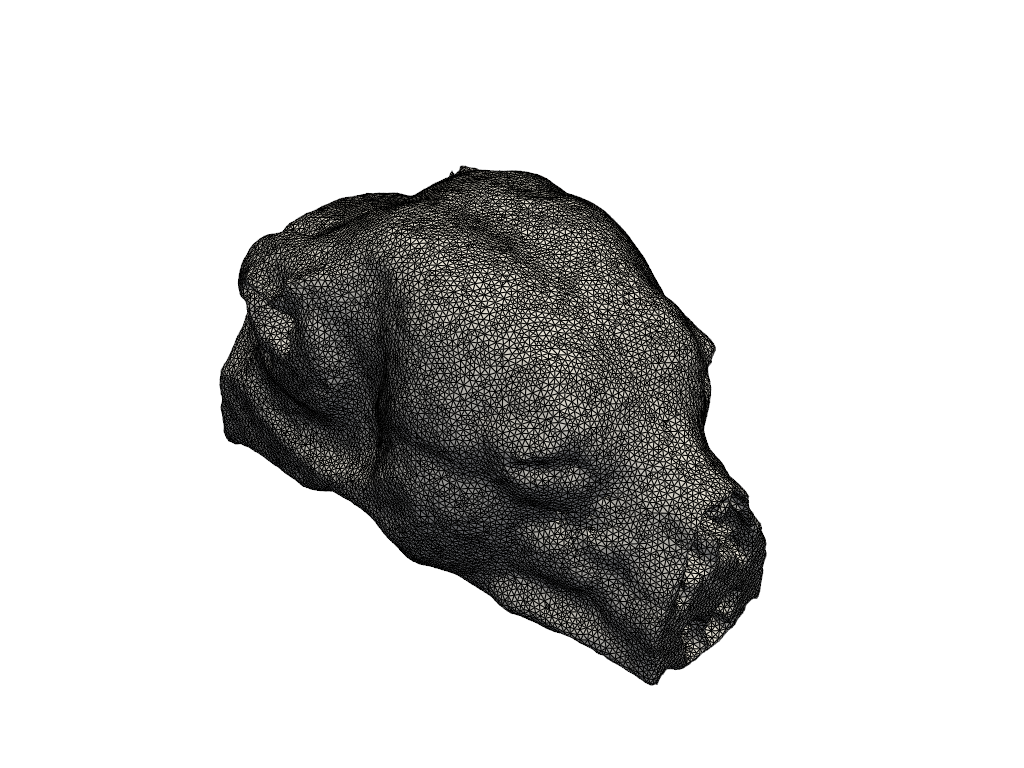

In [61]:
mesh = pv.read('../data/locations/odin_mesh.ply')
plotter = pv.Plotter()
plotter.add_mesh(mesh, color='white', show_edges=True)
plotter.show()

### 🔪 Display segmented tissues
- **AIR:** I guess some air?
- **CSF:** Either canine science forum or cerebrospinal fluid. The latter is more likely.
- **GM:** Grey matter
- **SCALP:** Das ist ja aber selbstverständlich.
- **SKULL:** 💀
- **WM:** White matter.

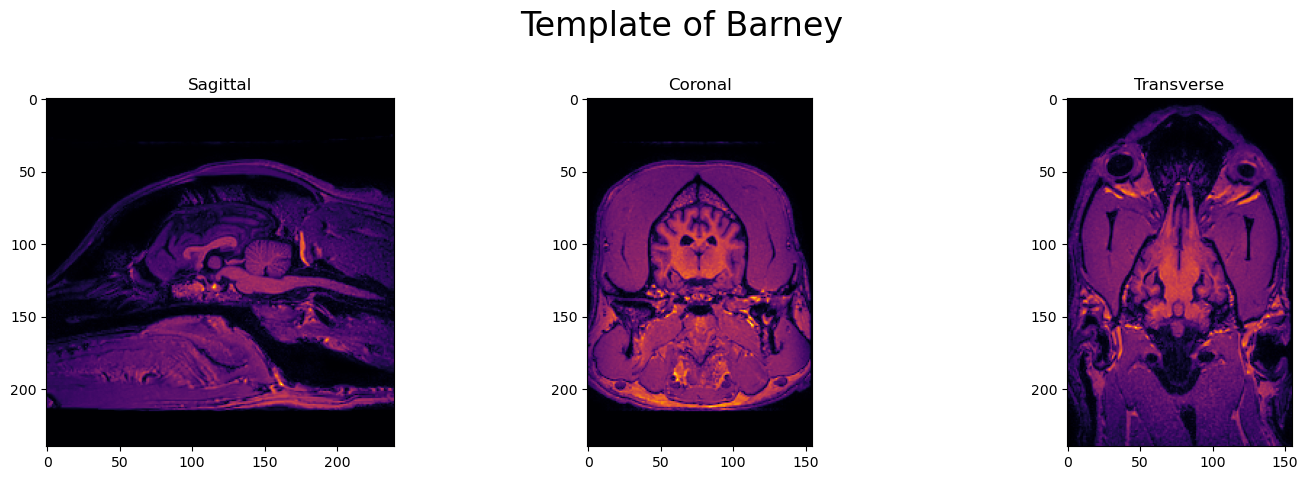

In [103]:
# Load a NIfTI file
nifti_file = '../data/templates/barney/barney.nii'
img = nib.load(nifti_file)

# Get the image data from the NIfTI file
data = img.get_fdata()

# Plotting
cmap = "inferno"
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(data[:, :, data.shape[2] // 2], cmap=cmap)
axes[1].imshow(data[:, data.shape[1] // 2, :], cmap=cmap)
axes[2].imshow(data[data.shape[0] // 2, :, :], cmap=cmap)

# Setting titles
axes[0].set_title('Sagittal')
axes[1].set_title('Coronal')
axes[2].set_title('Transverse')

# Add an overall title
fig.suptitle('Template of Barney',
                fontsize=24)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [77]:
# Load segmented nifti files
nifti_path = '../data/templates/' + template_name + '/'
air = nib.load(os.path.join(nifti_path, 'air.nii'))
csf = nib.load(os.path.join(nifti_path, 'csf.nii'))
gm = nib.load(os.path.join(nifti_path, 'gm.nii'))
scalp = nib.load(os.path.join(nifti_path, 'scalp.nii'))
skull = nib.load(os.path.join(nifti_path, 'skull.nii'))
wm = nib.load(os.path.join(nifti_path, 'wm.nii'))

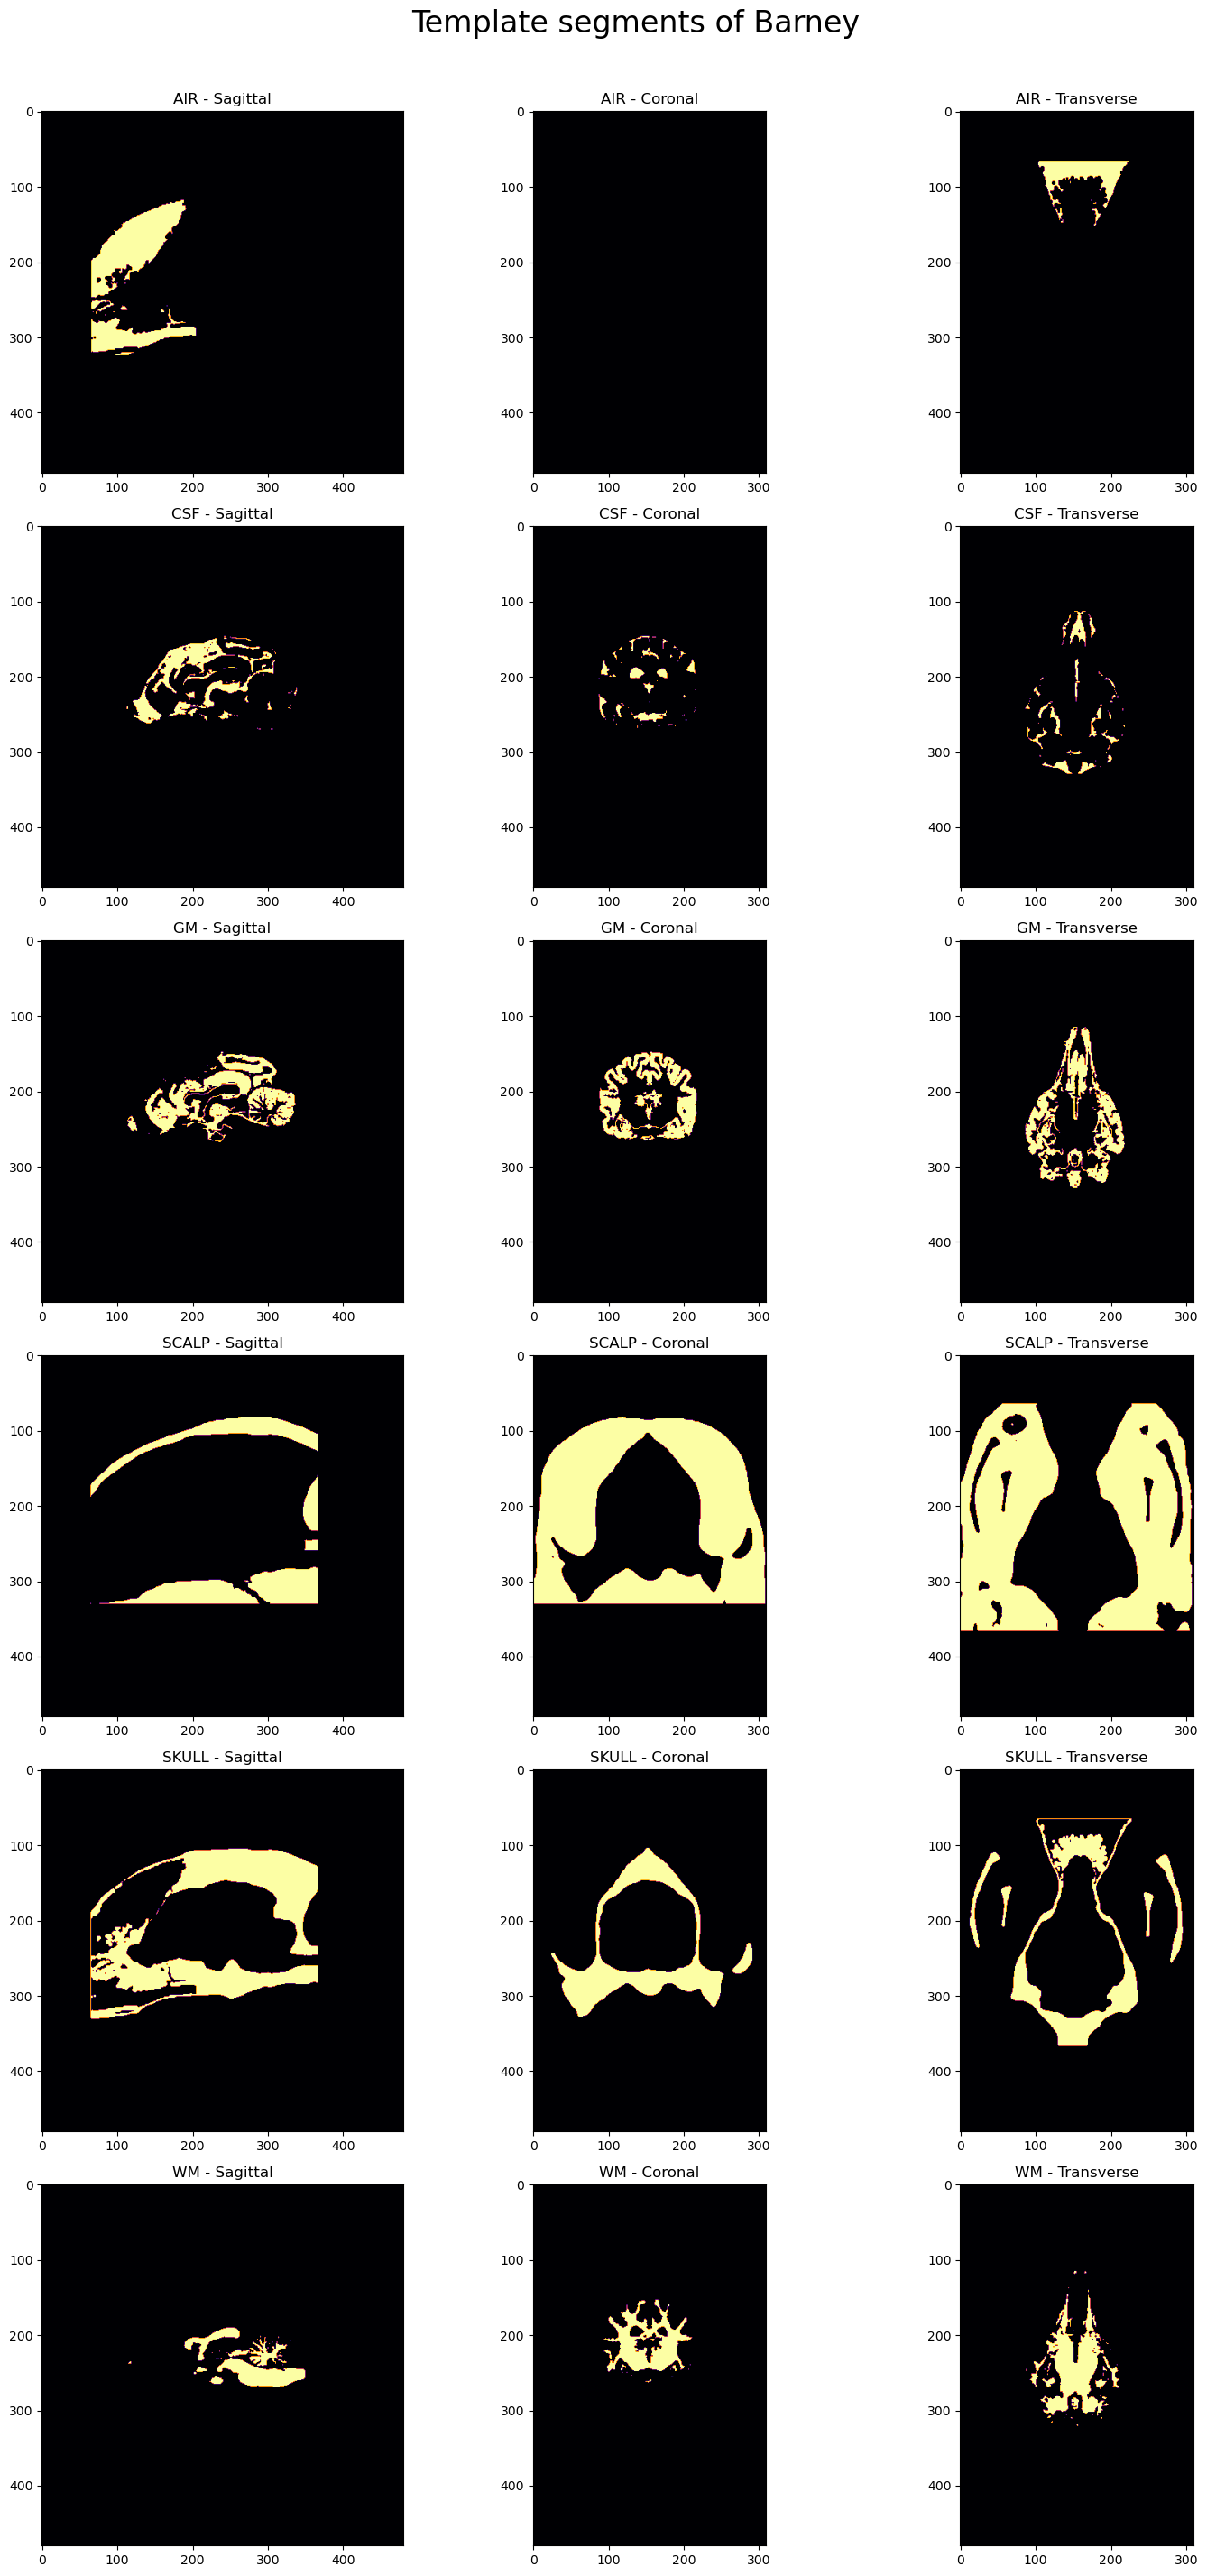

In [99]:
# Function to get the data and plot the images
def plot_nifti_data(ax, data, title):
    ax[0].imshow(data[:, :, data.shape[2] // 2], cmap=cmap)
    ax[1].imshow(data[:, data.shape[1] // 2, :], cmap=cmap)
    ax[2].imshow(data[data.shape[0] // 2, :, :], cmap=cmap)
    ax[0].set_title(f'{title.upper()} - Sagittal')
    ax[1].set_title(f'{title.upper()} - Coronal')
    ax[2].set_title(f'{title.upper()} - Transverse')

nifti_files = ['air', 'csf', 'gm', 'scalp', 'skull', 'wm']

# Create a subplot grid
fig, axes = plt.subplots(len(nifti_files), 3,
                figsize=(15, 5 * len(nifti_files)))

# Plot each NIFTI file
for i, file_name in enumerate(nifti_files):
    # Load the NIFTI file
    img = nib.load(os.path.join(nifti_path, f'{file_name}.nii'))

    # Get the image data
    data = img.get_fdata()

    # Plot the data
    plot_nifti_data(axes[i], data, file_name)

# Add an overall title
fig.suptitle(f'Template segments of {template_name.capitalize()}',
                fontsize=24)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


#### <span style = "color:yellow">Barney template</span>
This is not what we need. I already wrote Kalman to provide us with tissue segments.

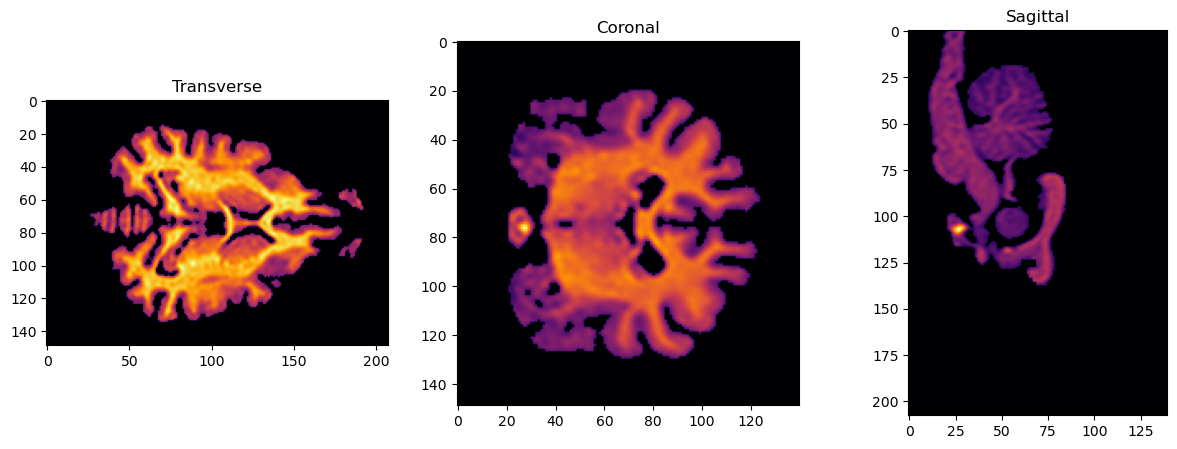

In [22]:
# Load the Barney template
barney_file = '../data/templates/barney/barney_extracted.nii'
img = nib.load(barney_file)

# Get the image data from the NIfTI file
data = img.get_fdata()

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(data[:, :, data.shape[2] // 2], cmap='inferno')
axes[1].imshow(data[:, data.shape[1] // 2, :], cmap='inferno')
axes[2].imshow(data[data.shape[0] // 2, :, :], cmap='inferno')

# Setting titles
axes[0].set_title('Transverse')
axes[1].set_title('Coronal')
axes[2].set_title('Sagittal')

# Show the plot
plt.show()

## 🔨 Raw preprocessing

### ✂️ Slice the data

In [12]:
# Find the onset times for 's' and 'e'
annotations = raw.annotations
onset_s = annotations.onset[annotations.description == 's'][0]
onset_e = annotations.onset[annotations.description == 'e'][0]

# Convert times to samples
start_sample = int(onset_s * raw.info['sfreq'])
end_sample = int(onset_e * raw.info['sfreq'])

# Trim the ends of the raw data
raw_cropped = raw.copy().crop(tmin=start_sample / raw.info['sfreq'], tmax=end_sample / raw.info['sfreq'])

In [13]:
raw_cropped

<RawSNIRF | odin.snirf, 3456 x 1815 (145.1 s), ~50.5 MB, data loaded>

In [14]:
raw_cropped.get_data().shape

(3456, 1815)

### 🔄 Resample the data
Note that lowpass is Nyquist frequency. It will remain half of the frequency after resampling.

In [15]:
# Define the desired resampling rate in Hz (1 = 1 per second)
resample_rate = 1.0

# Resample the data (Do not touch)
raw_resampled = raw_cropped.resample(resample_rate, npad='auto')
raw_resampled

<RawSNIRF | odin.snirf, 3456 x 145 (144.0 s), ~6.5 MB, data loaded>

In [16]:
raw_resampled.get_data().shape

(3456, 145)

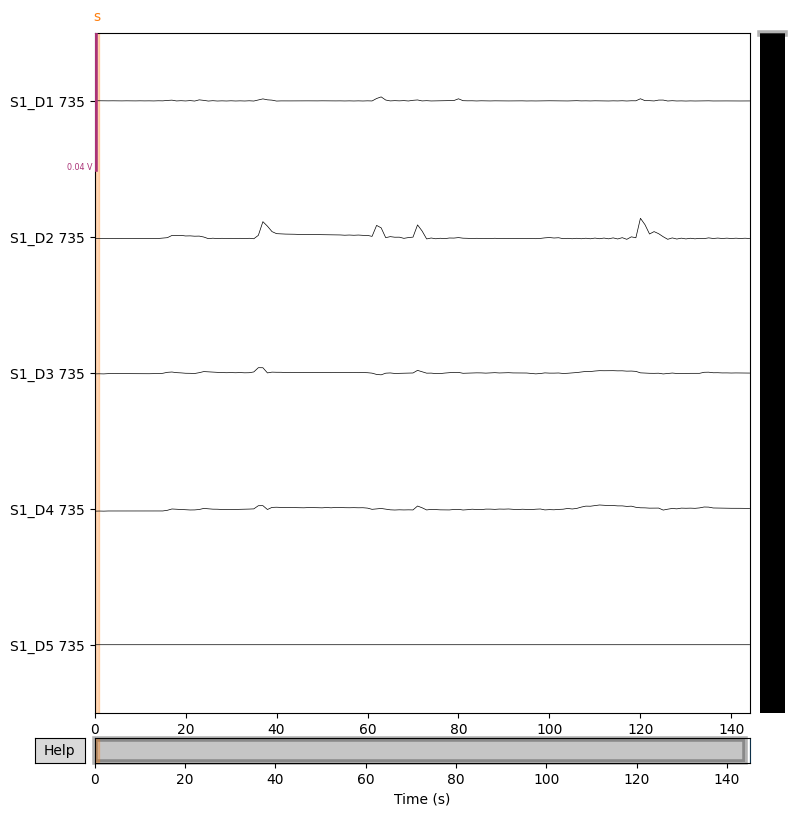

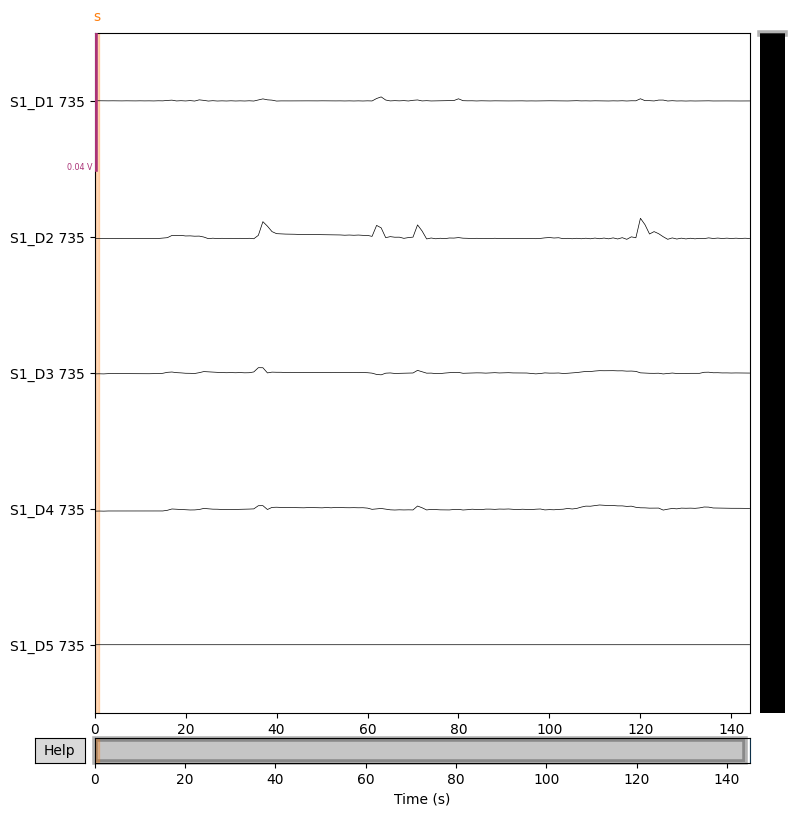

In [17]:
raw_resampled.plot(duration=600,          # Set it longer than the measurement, so you see all.
        n_channels=5,           # Look at the first 5 channels only.
        remove_dc=True)         # Remove the DC component from the data.

Note that the 'start' line is still apparent because annotations are stored as short duration intervals. There's nothing to be worry about.

## 🛝 Sandbox below this line

In [18]:
subjects_dir = op.join(mne.datasets.sample.data_path(), 'subjects')
mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, alpha=0.0, cortex='low_contrast', background="w")
brain.add_sensors(raw.info, trans='fsaverage', fnirs=["sources", "detectors"])
brain.show_view(azimuth=130, elevation=80, distance=700)

0 files missing from root.txt in /Users/rblc/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/rblc/mne_data/MNE-sample-data/subjects/fsaverage
Using pyvistaqt 3d backend.

Channel types::	fnirs_cw_amplitude: 3456


In [19]:
plot_kwargs = dict(subjects_dir=subjects_dir,
                   surfaces="brain", dig=True, eeg=[],
                   fnirs=['sources', 'detectors'], show_axes=True,
                   coord_frame='head', mri_fiducials=True)

fig = mne.viz.plot_alignment(trans="fsaverage", subject="fsaverage", **plot_kwargs)
set_3d_view(figure=fig, azimuth=90, elevation=0, distance=1)

/var/folders/x2/6gs4vmmn5bxgqplmvj03kx240000gn/T/ipykernel_91047/3778651853.py:6: RuntimeWarning: Digitization points not found. Cannot plot digitization.
  fig = mne.viz.plot_alignment(trans="fsaverage", subject="fsaverage", **plot_kwargs)


In [20]:
fig = mne.viz.plot_alignment(raw.info, trans="fsaverage", subject="fsaverage", **plot_kwargs)
set_3d_view(figure=fig, azimuth=90, elevation=0, distance=1)

Channel types::	fnirs_cw_amplitude: 3456


In [21]:
coreg = mne.coreg.Coregistration(raw.info, "fsaverage", subjects_dir, fiducials="estimated")
coreg.fit_fiducials(lpa_weight=1., nasion_weight=1., rpa_weight=1.)

fig = mne.viz.plot_alignment(raw.info, trans=coreg.trans, subject="fsaverage", **plot_kwargs)
set_3d_view(figure=fig, azimuth=90, elevation=0, distance=1)

Using high resolution head model in /Users/rblc/mne_data/MNE-sample-data/subjects/fsaverage/bem/fsaverage-head-dense.fif
    Triangle neighbors and vertex normals...
Estimating fiducials from fsaverage.
Aligning using fiducials
Start median distance:  71.02 mm
End   median distance:  16.32 mm
Channel types::	fnirs_cw_amplitude: 3456


In [22]:
brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, background='w', cortex='0.5', alpha=0.3)
brain.add_sensors(raw.info, trans=coreg.trans, fnirs=['sources', 'detectors'])
brain.show_view(azimuth=90, elevation=90, distance=500)

Channel types::	fnirs_cw_amplitude: 3456


In [23]:
mtg = raw.get_montage()
mtg.apply_trans(coreg.trans)
raw.set_montage(mtg)

<RawSNIRF | odin.snirf, 3456 x 1893 (151.4 s), ~52.6 MB, data loaded>

In [24]:
mne_nirs.io.write_raw_snirf(raw, "raw_coregistered_to_fsaverage.snirf")

In [25]:
raw_w_coreg = mne.io.read_raw_snirf("raw_coregistered_to_fsaverage.snirf")

# Now you can simply use `trans = "fsaverage"`.
brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, background='w', cortex='0.5', alpha=0.3)
brain.add_sensors(raw_w_coreg.info, trans="fsaverage", fnirs=['sources', 'detectors'])

Loading /Users/rblc/ELTE/hddotter/scripts/raw_coregistered_to_fsaverage.snirf
Channel types::	fnirs_cw_amplitude: 3456
